# Montecarlo aproximated function



In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [3]:
%matplotlib inline
from collections import defaultdict
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots

In [4]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [5]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

In [6]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

# Reward Policy

In [7]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

# Hyper Parameters

In [8]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 50
reward_policy.REWARD_IF_COLISION = -1
reward_policy.REWARD_IF_STILL = -0.1

# MonteCarlo

In [9]:
env, initial_state = environment.get_env()

In [10]:
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [11]:
def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

In [12]:
episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=False)

In [13]:
import pickle

In [14]:
def saveHistory(config,scores,total_rewards):
    base="history/"
    with open(base+"scores_"+config+".pickle", 'wb') as handle:
        pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(base+"total_rewards_"+config+".pickle", 'wb') as handle:
        pickle.dump(total_rewards, handle, protocol=pickle.HIGHEST_PROTOCOL)    
    print("Scores and Total rewards for "+config+" saved")
def loadHistory(fileDir):
    with open(fileDir, 'rb') as handle:
        data = pickle.load(handle)
        return data

In [ ]:
%%time
MonteCarloES(RAM_mask=RAM_mask, render=False)

In [ ]:
scores = []
total_rewards = []

In [15]:
%%time

n_runs = 2500

for i in range(n_runs):
    render = i % 201 == 200

    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

Run [   0] - Total reward:  464.60 Mean scores: 13.00 Means Scores[:-10]: 13.00 Score: 13 
Run [  10] - Total reward:  443.10 Mean scores: 11.91 Means Scores[:-10]: 11.80 Score: 13 
Run [  20] - Total reward:  450.00 Mean scores: 11.95 Means Scores[:-10]: 12.00 Score: 13 
Run [  30] - Total reward:  459.10 Mean scores: 12.06 Means Scores[:-10]: 12.30 Score: 13 
Run [  40] - Total reward:  464.70 Mean scores: 11.95 Means Scores[:-10]: 11.60 Score: 13 
Run [  50] - Total reward:  457.90 Mean scores: 12.00 Means Scores[:-10]: 12.20 Score: 13 
Run [  60] - Total reward:  400.60 Mean scores: 12.00 Means Scores[:-10]: 12.00 Score: 12 
Run [  70] - Total reward:  559.50 Mean scores: 12.06 Means Scores[:-10]: 12.40 Score: 15 
Run [  80] - Total reward:  285.40 Mean scores: 12.00 Means Scores[:-10]: 11.60 Score: 10 
Run [  90] - Total reward:  294.50 Mean scores: 12.01 Means Scores[:-10]: 12.10 Score: 10 
Run [ 100] - Total reward:  407.00 Mean scores: 12.08 Means Scores[:-10]: 12.70 Score: 12 

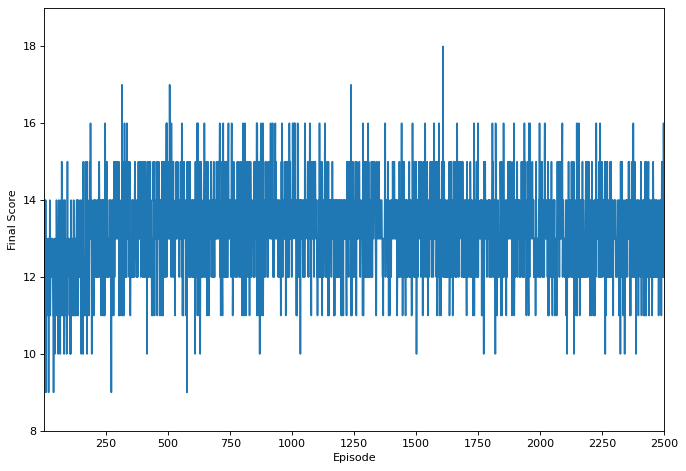

In [21]:
aux_plots.plot_scores(scores)

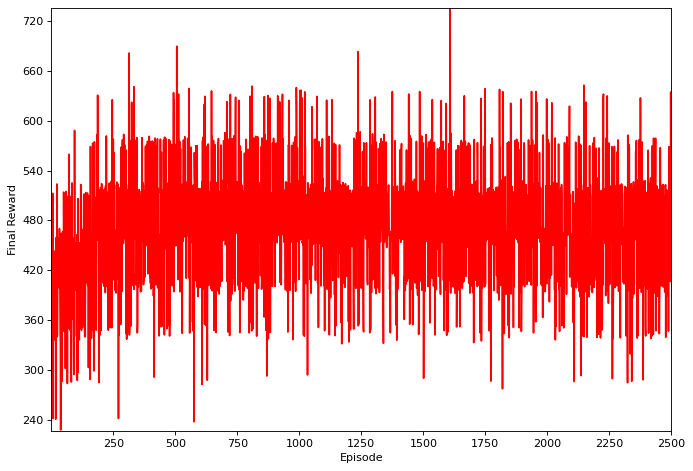

In [22]:
aux_plots.plot_rewards(total_rewards)

In [28]:
saveHistory("Episode2500",scores,total_rewards)

Scores and Total rewards for Episode2500 saved


# MonteCarlo Approximation

In [15]:
env, initial_state = environment.get_env()

In [18]:
agent = agents.MonteCarloAprox(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0,nFeatures=len(RAM_mask)+1)

In [19]:
scores = []
total_rewards = []

In [35]:
def MonteCarloAprox(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    
    return agent.updating(epi)

In [21]:
from tqdm import tqdm

In [40]:
%%time

n_runs = 1

for i in tqdm(range(n_runs)):
    render = i % 201 == 200
    score, total_reward = MonteCarloAprox(RAM_mask=RAM_mask, render=render)
    scores.append(score)
    total_rewards.append(total_reward)
    print_result(i, scores, total_reward, score)

  0%|          | 0/1 [00:00<?, ?it/s]

2722
Update in 125 : [ 44.33421053   0.         148.65         0.           0.
  68.60769231 142.93269231   0.           0.          51.45576923
 114.34615385 148.65       148.65      ]
Update in 126 : [ -95.77461255    0.         -295.02793973    0.            0.
 -153.23127756 -300.74524742 -443.67793973    0.          -85.06051992
 -226.94456902 -295.02793973 -295.02793973]
Update in 127 : [ 350.07970908 1337.56296489 -295.02793973    0.            0.
  515.55020489 -300.74524742  893.88502516    0.          326.49731543
  750.50528993 1042.53502516 -295.02793973]
Update in 128 : [ -483.82624453  1337.56296489  -295.02793973     0.
     0.          -906.36635705  -300.74524742 -1645.25169258
     0.          -486.02643424 -1179.23861555 -1598.16716129
  -295.02793973]
Update in 129 : [1112.98952373 1337.56296489 -295.02793973    0.            0.
 1976.57251868 -300.74524742 3296.92923724    0.         1161.36720903
 2733.32128723 3755.86217935 5059.00140091]
Update in 130 : [ -3111.

Update in 468 : [ 3.81344554e+07  1.33756296e+03 -6.52248647e+04  1.84965496e+07
 -8.00019617e+04  3.60723593e+07  3.04613414e+06 -1.03288822e+07
 -7.73227408e+04  1.09582881e+06  1.02704122e+04  1.55526163e+07
  5.41531514e+07]
Update in 469 : [-3.06535347e+07  1.33756296e+03 -6.52248647e+04 -1.38186875e+07
 -8.00019617e+04 -2.85581149e+07  3.04613414e+06 -1.03288822e+07
 -7.73227408e+04  1.09582881e+06  1.02704122e+04 -1.40696844e+07
 -1.58631957e+07]
Update in 470 : [-3.06535347e+07  1.33756296e+03 -6.52248647e+04  4.03914616e+06
 -8.00019617e+04  7.15755246e+06  3.04613414e+06 -1.03288822e+07
 -7.73227408e+04  1.09582881e+06  1.02704122e+04  2.29999653e+06
 -1.58631957e+07]
Update in 471 : [-3.06535347e+07  1.33756296e+03 -6.52248647e+04  1.79622223e+06
 -8.00019617e+04  2.48479427e+06  3.04613414e+06 -1.03288822e+07
 -7.73227408e+04  1.09582881e+06  1.02704122e+04  2.43982927e+05
 -1.58631957e+07]
Update in 472 : [-3.06535347e+07  1.33756296e+03 -6.52248647e+04  1.01053171e+05
 -8

  3.75844971e+16]
Update in 995 : [ 1.32862441e+16  1.44665633e+17 -1.02330674e+16 -5.89196964e+16
 -5.43612016e+16 -3.59569238e+16  5.18493759e+16 -2.35174737e+16
 -8.18455861e+15  1.16844406e+16  1.99321872e+16 -3.20077687e+16
 -4.78905175e+15]
Update in 996 : [ 1.72115169e+16  1.44665633e+17 -1.02330674e+16 -5.89196964e+16
 -4.05925522e+16 -1.53039497e+16  5.18493759e+16 -2.35174737e+16
 -8.18455861e+15  1.16844406e+16  3.19797554e+16 -2.25418222e+16
 -4.78905175e+15]
Update in 997 : [ 1.88725840e+16  1.44665633e+17 -1.02330674e+16 -5.89196964e+16
 -3.47660400e+16 -6.56418138e+15  5.18493759e+16 -2.35174737e+16
 -8.18455861e+15  1.16844406e+16  3.70779536e+16 -1.85360951e+16
 -4.78905175e+15]
Update in 998 : [ 1.94623715e+16  1.44665633e+17 -1.02330674e+16 -5.89196964e+16
 -3.26972468e+16 -3.46099158e+15  5.18493759e+16 -2.35174737e+16
 -8.18455861e+15  1.16844406e+16  3.88881477e+16 -1.71137998e+16
 -1.42726280e+15]
Update in 999 : [ 2.05738610e+16  1.44665633e+17 -1.02330674e+16 -

Update in 1518 : [ 6.70089500e+20  1.81276770e+21  3.03774722e+19  5.93802496e+20
  2.22251535e+20  1.41293498e+21  2.47173677e+20  1.93051833e+21
  2.86693648e+19  2.16716240e+21 -3.27667930e+17  1.28922518e+21
  2.97187097e+21]
Update in 1519 : [-2.05910546e+21  1.81276770e+21  3.03774722e+19 -2.06541311e+21
  2.22251535e+20 -3.57309427e+21  2.47173677e+20 -5.38232458e+21
  2.86693648e+19 -6.14288636e+21 -3.27667930e+17 -3.69680407e+21
 -5.67057974e+21]
Update in 1520 : [ 3.80309983e+21  1.81276770e+21  3.03774722e+19  4.36046577e+21
  2.22251535e+20  9.27866348e+21  2.47173677e+20  1.06823726e+22
  2.86693648e+19  1.31347503e+22 -3.27667930e+17  7.54848396e+21
  1.52135266e+22]
Update in 1521 : [-7.61858512e+20  1.81276770e+21  3.03774722e+19 -6.43430874e+20
  2.22251535e+20 -7.29129806e+20  2.47173677e+20 -1.82736900e+21
  2.86693648e+19 -1.87693966e+21 -3.27667930e+17 -1.20833516e+21
  1.52135266e+22]
Update in 1522 : [-3.55652518e+21  1.81276770e+21  3.03774722e+19 -3.91104114e+2

100%|██████████| 1/1 [00:03<00:00,  3.50s/it]

 [ 3.03601744e+43  3.00870112e+27 -8.26077006e+43 -2.67998981e+38
 -2.54177540e+43 -4.48514894e+42 -5.10930969e+43  4.04153028e+42
  1.07582866e+43 -2.12966197e+42 -4.31875549e+43 -6.52866065e+43
  4.29879773e+43]
Update in 2264 : [ 6.05853968e+43  3.00870112e+27  1.08818708e+44 -2.67998981e+38
  4.08452336e+43  9.12280553e+43  1.40333312e+44  1.95467939e+44
  1.07582866e+43 -2.12966197e+42  1.04063529e+44  1.26139802e+44
  2.34414386e+44]
Update in 2265 : [-7.44066044e+43  3.00870112e+27  1.08818708e+44 -2.67998981e+38
 -2.01290769e+44 -2.85427948e+44  1.40333312e+44 -4.77132067e+44
  1.07582866e+43 -2.12966197e+42 -4.07112476e+44 -5.73364204e+44
 -4.65089620e+44]
Update in 2266 : [ 3.49892930e+44  3.00870112e+27  1.08818708e+44 -2.67998981e+38
  4.96355582e+44  7.99799708e+44  1.40333312e+44  1.38325820e+45
  1.07582866e+43 -2.12966197e+42  1.06569649e+45  1.44205859e+45
  1.55033317e+45]
Update in 2267 : [-6.02668914e+44  3.00870112e+27  1.08818708e+44 -2.67998981e+38
 -1.11003569e+